Import libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

데이터 로드

In [37]:
df=pd.read_csv("dataset/no_fault.csv")
df

,sensor1,sensor2,time_x,speedSet,load_value,gear_fault_desc
0,2.523465,2.430168,2023-05-03 21:47:31.000000,8.332031,0,No fault
1,2.521494,2.430003,2023-05-03 21:47:31.000200,8.332031,0,No fault
2,2.522479,2.429675,2023-05-03 21:47:31.000400,8.332031,0,No fault
3,2.521330,2.431810,2023-05-03 21:47:31.000600,8.332031,0,No fault
4,2.522479,2.431317,2023-05-03 21:47:31.000800,8.332031,0,No fault
...,...,...,...,...,...,...
149995,2.549417,2.441830,2023-05-03 22:06:06.999000,40.000000,80,No fault
149996,2.496363,2.453820,2023-05-03 22:06:06.999200,40.000000,80,No fault
149997,2.520837,2.418505,2023-05-03 22:06:06.999400,40.000000,80,No fault
149998,2.499319,2.417027,2023-05-03 22:06:06.999600,40.000000,80,No fault


데이터 전처리

In [38]:
df.head()

,sensor1,sensor2,time_x,speedSet,load_value,gear_fault_desc
0,2.523465,2.430168,2023-05-03 21:47:31.000000,8.332031,0,No fault
1,2.521494,2.430003,2023-05-03 21:47:31.000200,8.332031,0,No fault
2,2.522479,2.429675,2023-05-03 21:47:31.000400,8.332031,0,No fault
3,2.521330,2.431810,2023-05-03 21:47:31.000600,8.332031,0,No fault
4,2.522479,2.431317,2023-05-03 21:47:31.000800,8.332031,0,No fault


In [39]:
date_time = pd.to_datetime(df.pop('time_x'), format='%Y-%m-%d %H:%M:%S.%f')
df=df.drop(['gear_fault_desc'], axis=1)
df = df[['speedSet', 'load_value','sensor1', 'sensor2']]

In [40]:
df.head()

,speedSet,load_value,sensor1,sensor2
0,8.332031,0,2.523465,2.430168
1,8.332031,0,2.521494,2.430003
2,8.332031,0,2.522479,2.429675
3,8.332031,0,2.521330,2.431810
4,8.332031,0,2.522479,2.431317


In [41]:
df.describe()

,speedSet,load_value,sensor1,sensor2
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,24.444010,40.000000,2.520499,2.429825
std,12.934413,40.000133,0.007967,0.006862
min,8.332031,0.000000,2.451357,2.378756
25%,8.332031,0.000000,2.517223,2.426882
50%,25.000000,40.000000,2.520837,2.430003
75%,40.000000,80.000000,2.523136,2.432139
max,40.000000,80.000000,2.592781,2.493242


Train, test 데이터 분할

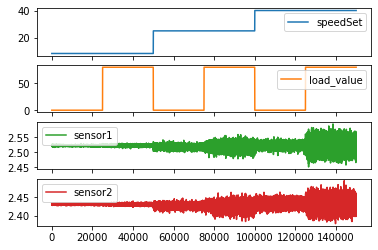

In [43]:
#데이터 확인
plot_cols = ['speedSet', 'load_value','sensor1', 'sensor2']
plot_features = df[plot_cols]
#plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [45]:
#train/test data 분할
# 10개 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

#train_set = pd.concat([df.iloc[0:20000+2500], df.iloc[25000:45000+2500], df.iloc[50000:70000+2500],
#                        df.iloc[75000:95000+2500], df.iloc[100000:120000+2500], df.iloc[125000:145000+2500]])

#test_set = pd.concat([df.iloc[20000+2500:25000], df.iloc[45000+2500:50000], df.iloc[70000+2500:75000],
#                       df.iloc[95000+2500:100000], df.iloc[120000+2500:125000], df.iloc[145000+2500:]])

data=0
train_set = df[data*25000:data*25000+14000]
test_set = df[data*25000+14000-seq_length:data*25000+20000]

#train_set = df[data*25000+2500:data*25000+25000]
#test_set = df[data*25000:data*25000+2500]


# train_set.reset_index(drop=True, inplace=True)
# test_set.reset_index(drop=True, inplace=True)



In [46]:
train_set

,speedSet,load_value,sensor1,sensor2
0,8.332031,0,2.523465,2.430168
1,8.332031,0,2.521494,2.430003
2,8.332031,0,2.522479,2.429675
3,8.332031,0,2.521330,2.431810
4,8.332031,0,2.522479,2.431317
...,...,...,...,...
13995,8.332031,0,2.521165,2.431646
13996,8.332031,0,2.521987,2.430168
13997,8.332031,0,2.521494,2.430825
13998,8.332031,0,2.521165,2.430825


In [47]:
test_set

,speedSet,load_value,sensor1,sensor2
13993,8.332031,0,2.521165,2.430496
13994,8.332031,0,2.520508,2.430989
13995,8.332031,0,2.521165,2.431646
13996,8.332031,0,2.521987,2.430168
13997,8.332031,0,2.521494,2.430825
...,...,...,...,...
19995,8.332031,0,2.519194,2.430496
19996,8.332031,0,2.519687,2.429346
19997,8.332031,0,2.520016,2.429675
19998,8.332031,0,2.520344,2.430003


In [48]:
# 7개 데이터가 입력으로 들어가고 batch size는 임의로 지정
#seq_length = 10
#batch = 100
#train_size = int(len(df)*0.7)
#train_set = df[0:train_size]
#test_set = df[train_size-seq_length:]
#test_date_time=date_time[train_size-seq_length:]

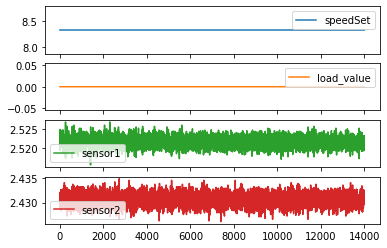

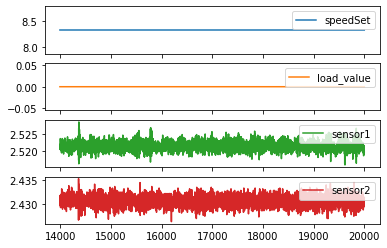

In [50]:
plot_cols = ['speedSet', 'load_value','sensor1','sensor2']
plot_features = train_set[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = test_set[plot_cols]
_ = plot_features.plot(subplots=True)

데이터 스케일링

In [51]:
# Input scale
train_set = train_set.copy()
test_set = test_set.copy()

scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])


train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

In [52]:
print(test_set[0:5])

       speedSet  load_value   sensor1   sensor2
13993       0.0         0.0  0.492754  0.500000
13994       0.0         0.0  0.434783  0.555556
13995       0.0         0.0  0.492754  0.629630
13996       0.0         0.0  0.565217  0.462963
13997       0.0         0.0  0.521739  0.537037


In [53]:
train_set.head()

,speedSet,load_value,sensor1,sensor2
0,0.0,0.0,0.695652,0.462963
1,0.0,0.0,0.521739,0.444444
2,0.0,0.0,0.608696,0.407407
3,0.0,0.0,0.507246,0.648148
4,0.0,0.0,0.608696,0.592593


데이터셋 생성

In [54]:
device = torch.device('cuda')
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)


# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

testX_tensor = testX_tensor.to(device)
testY_tensor = testY_tensor.to(device)
# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True)

In [55]:
trainX_tensor.shape

torch.Size([13993, 7, 4])

In [56]:
next(iter(dataloader))

[tensor([[[0.0000, 0.0000, 0.4348, 0.5185],
          [0.0000, 0.0000, 0.4348, 0.5000],
          [0.0000, 0.0000, 0.4203, 0.4630],
          ...,
          [0.0000, 0.0000, 0.4493, 0.3148],
          [0.0000, 0.0000, 0.5507, 0.3889],
          [0.0000, 0.0000, 0.5652, 0.5185]],
 
         [[0.0000, 0.0000, 0.6957, 0.4259],
          [0.0000, 0.0000, 0.4928, 0.4259],
          [0.0000, 0.0000, 0.4928, 0.5370],
          ...,
          [0.0000, 0.0000, 0.7681, 0.4259],
          [0.0000, 0.0000, 0.6522, 0.4444],
          [0.0000, 0.0000, 0.4493, 0.5741]],
 
         [[0.0000, 0.0000, 0.6522, 0.6481],
          [0.0000, 0.0000, 0.5507, 0.4259],
          [0.0000, 0.0000, 0.4348, 0.4630],
          ...,
          [0.0000, 0.0000, 0.2319, 0.5556],
          [0.0000, 0.0000, 0.5362, 0.5741],
          [0.0000, 0.0000, 0.6232, 0.6111]],
 
         ...,
 
         [[0.0000, 0.0000, 0.4348, 0.5370],
          [0.0000, 0.0000, 0.5072, 0.5370],
          [0.0000, 0.0000, 0.4638, 0.4815],
      

In [57]:
print(testX_tensor[0:2])

tensor([[[0.0000, 0.0000, 0.4928, 0.5000],
         [0.0000, 0.0000, 0.4348, 0.5556],
         [0.0000, 0.0000, 0.4928, 0.6296],
         [0.0000, 0.0000, 0.5652, 0.4630],
         [0.0000, 0.0000, 0.5217, 0.5370],
         [0.0000, 0.0000, 0.4928, 0.5370],
         [0.0000, 0.0000, 0.5072, 0.6111]],

        [[0.0000, 0.0000, 0.4348, 0.5556],
         [0.0000, 0.0000, 0.4928, 0.6296],
         [0.0000, 0.0000, 0.5652, 0.4630],
         [0.0000, 0.0000, 0.5217, 0.5370],
         [0.0000, 0.0000, 0.4928, 0.5370],
         [0.0000, 0.0000, 0.5072, 0.6111],
         [0.0000, 0.0000, 0.6377, 0.6296]]], device='cuda:0')


LSTM

In [58]:
import torch.nn as nn

# 설정값
#data_dim = 4
#hidden_dim = 15
#output_dim = 1
#learning_rate = 0.01
#nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            #dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

Training

In [59]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping : %04d epoch' %(epoch))

                break

    return model.eval(), train_hist

학습 시작

In [86]:
# 모델 학습
# 설정값
data_dim = 4
hidden_dim = 256
output_dim = 1
learning_rate = 0.001
n_layer=2
nb_epochs = 200
net = Net(data_dim, hidden_dim, seq_length, output_dim, n_layer)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 1, patience = 10)

Epoch: 0000 train loss : 0.0196
Epoch: 0001 train loss : 0.0136
Epoch: 0002 train loss : 0.0132
Epoch: 0003 train loss : 0.0122
Epoch: 0004 train loss : 0.0108
Epoch: 0005 train loss : 0.0108
Epoch: 0006 train loss : 0.0110
Epoch: 0007 train loss : 0.0107
Epoch: 0008 train loss : 0.0108
Epoch: 0009 train loss : 0.0107
Epoch: 0010 train loss : 0.0107
Epoch: 0011 train loss : 0.0108
Epoch: 0012 train loss : 0.0106
Epoch: 0013 train loss : 0.0107
Epoch: 0014 train loss : 0.0107
Epoch: 0015 train loss : 0.0107
Epoch: 0016 train loss : 0.0107
Epoch: 0017 train loss : 0.0108
Epoch: 0018 train loss : 0.0107
Epoch: 0019 train loss : 0.0107
Epoch: 0020 train loss : 0.0107
Epoch: 0021 train loss : 0.0107
Epoch: 0022 train loss : 0.0107
Epoch: 0023 train loss : 0.0106
Epoch: 0024 train loss : 0.0106
Epoch: 0025 train loss : 0.0106
Epoch: 0026 train loss : 0.0107
Epoch: 0027 train loss : 0.0106
Epoch: 0028 train loss : 0.0106
Epoch: 0029 train loss : 0.0106
Epoch: 0030 train loss : 0.0106
Epoch: 0

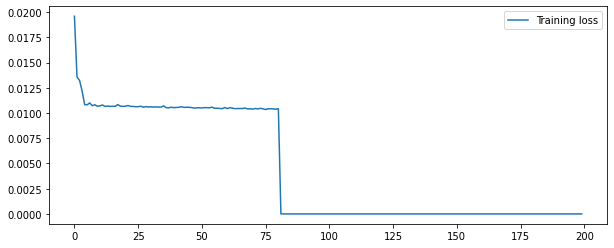

In [87]:
# 
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [110]:
# 모델 저장
PATH ="model/model0.pth"
#torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, n_layer)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()
model.to(device)

Net(
  (lstm): LSTM(4, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

모델 테스트

In [111]:
print(testX_tensor[0:2])
print(testY_tensor[0:2])

tensor([[[0.0000, 0.0000, 0.4928, 0.5000],
         [0.0000, 0.0000, 0.4348, 0.5556],
         [0.0000, 0.0000, 0.4928, 0.6296],
         [0.0000, 0.0000, 0.5652, 0.4630],
         [0.0000, 0.0000, 0.5217, 0.5370],
         [0.0000, 0.0000, 0.4928, 0.5370],
         [0.0000, 0.0000, 0.5072, 0.6111]],

        [[0.0000, 0.0000, 0.4348, 0.5556],
         [0.0000, 0.0000, 0.4928, 0.6296],
         [0.0000, 0.0000, 0.5652, 0.4630],
         [0.0000, 0.0000, 0.5217, 0.5370],
         [0.0000, 0.0000, 0.4928, 0.5370],
         [0.0000, 0.0000, 0.5072, 0.6111],
         [0.0000, 0.0000, 0.6377, 0.6296]]], device='cuda:0')
tensor([[0.6296],
        [0.4074]], device='cuda:0')


In [114]:
# 예측테스트
a=1


testX_tensor_100=testX_tensor[a*100:a*100+100]
testY_tensor_100=testY_tensor[a*100:a*100+100]
testX_tensor_100 = testX_tensor_100.to(device)
testY_tensor_100 = testY_tensor_100.to(device)

with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor_100)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor_100[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    # pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    # testY_inverse = scaler_y.inverse_transform(testY_tensor_100)
    pred_np = np.array(pred).reshape(-1, 1)
    pred_inverse = scaler_y.inverse_transform(pred_np)

    # GPU에서 CPU로 이동
    testY_np = testY_tensor_100.cpu().numpy()
    testY_inverse = scaler_y.inverse_transform(testY_np)


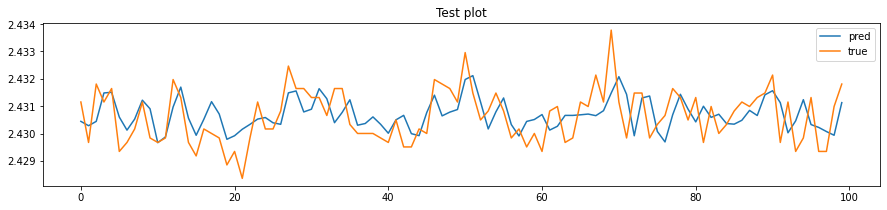

In [115]:
fig = plt.figure(figsize=(15,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Test plot")
plt.legend()
plt.show()